In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.optim.lr_scheduler import StepLR

from model import EfficientNet_B0

from torchvision import transforms
from sklearn.metrics import average_precision_score
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from voc_dataloader import VocDataset, VOC_CLASSES

%load_ext autoreload
%autoreload 2

In [2]:
batch = 128

transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

classifier = EfficientNet_B0().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(classifier.parameters(), lr=0.001, momentum=0.9)
# optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)

In [4]:
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = classifier(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 199))
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 2.444
[2,   200] loss: 1.697
[3,   200] loss: 1.511
[4,   200] loss: 1.390
[5,   200] loss: 1.304
[6,   200] loss: 1.242
[7,   200] loss: 1.178
[8,   200] loss: 1.128
[9,   200] loss: 1.071
[10,   200] loss: 1.031
[11,   200] loss: 0.989
[12,   200] loss: 0.941
[13,   200] loss: 0.915
[14,   200] loss: 0.864
[15,   200] loss: 0.830
[16,   200] loss: 0.805
[17,   200] loss: 0.774
[18,   200] loss: 0.742
[19,   200] loss: 0.712
[20,   200] loss: 0.689
[21,   200] loss: 0.658
[22,   200] loss: 0.626
[23,   200] loss: 0.593
[24,   200] loss: 0.586
[25,   200] loss: 0.565
[26,   200] loss: 0.538
[27,   200] loss: 0.521
[28,   200] loss: 0.483
[29,   200] loss: 0.473
[30,   200] loss: 0.459
[31,   200] loss: 0.434
[32,   200] loss: 0.422
[33,   200] loss: 0.409
[34,   200] loss: 0.392
[35,   200] loss: 0.367
[36,   200] loss: 0.357
[37,   200] loss: 0.344
[38,   200] loss: 0.342
[39,   200] loss: 0.319
[40,   200] loss: 0.316
[41,   200] loss: 0.293
[42,   200] loss: 0.286
[

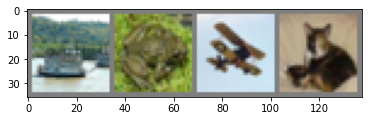

 ship  frog plane   cat


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[0:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [6]:
outputs = classifier(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   ship  frog plane   cat


In [7]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = classifier(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 62 %


In [8]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = classifier(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 65 %
Accuracy of   car : 78 %
Accuracy of  bird : 45 %
Accuracy of   cat : 44 %
Accuracy of  deer : 44 %
Accuracy of   dog : 54 %
Accuracy of  frog : 69 %
Accuracy of horse : 52 %
Accuracy of  ship : 81 %
Accuracy of truck : 74 %


## Luke's pretrianed model